In [1]:
import uproot
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import scipy.optimize as opt
import vector

file = uproot.open("data_A.2lep.root")
print(file.keys())  

tree = file["mini"]

#print(tree.keys()) 

['mini;1']


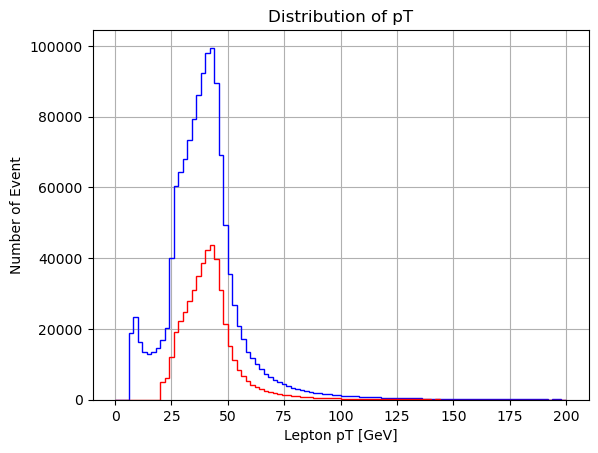

All Events: 668152
2 lepton: 664613
... + pT > 20 GeV: 555056
... + |eta| < 2.5: 549246
... + opposite charge: 541459
... + flavor == muon: 270621
... + tight ID: 240075
... + truth matched: 240075


In [2]:
lep_n = tree["lep_n"].array()  
lep_pt = tree["lep_pt"].array()  
lep_eta = tree["lep_eta"].array()
lep_charge = tree["lep_charge"].array()
lep_type = tree["lep_type"].array()
lep_isTightID = tree["lep_isTightID"].array()
lep_truthMatched = tree["lep_truthMatched"].array()

# Cut Conditions
lep_cutn = lep_n == 2
lep_cutpt = ak.all(lep_pt > 20000, axis=1)
lep_cuteta = ak.all(abs(lep_eta) < 2.5, axis=1)
lep_cutcharge = ak.sum(lep_charge, axis=1)==0
lep_flavor = ak.all((lep_type == 13), axis=1) 
lep_tight = ak.all(lep_isTightID == 1, axis=1)
lep_truth = ak.all(lep_truthMatched == 1, axis=1)

combined_mask = lep_cutn & lep_cutpt & lep_cuteta & lep_cutcharge & lep_flavor & lep_tight & lep_truth

# Cut Data
lep_pt_cut = lep_pt[combined_mask]
lep_pt_cut_flat = ak.flatten(lep_pt_cut)
lep_pt_gev_cut = lep_pt_cut_flat / 1000  # Convert to GeV

# Pure Data
lep_pt_flat = ak.flatten(lep_pt)
lep_pt_gev = lep_pt_flat / 1000  # Convert to GeV


plt.hist(lep_pt_gev, bins=100, range=(0, 200), histtype='step', color='blue', label='Pure Data')
plt.hist(lep_pt_gev_cut, bins=100, range=(0, 200), histtype='step', color='red', label='Cut Data')
plt.xlabel("Lepton pT [GeV]")
plt.ylabel("Number of Event")
plt.title("Distribution of pT")
plt.grid(True)
plt.savefig("histogram2.png")
plt.show()

print("All Events:", len(lep_n))
print("2 lepton:", ak.sum(lep_cutn))
print("... + pT > 20 GeV:", ak.sum(lep_cutn & lep_cutpt))
print("... + |eta| < 2.5:", ak.sum(lep_cutn & lep_cutpt & lep_cuteta))
print("... + opposite charge:", ak.sum(lep_cutn & lep_cutpt & lep_cuteta & lep_cutcharge))
print("... + flavor == muon:", ak.sum(lep_cutn & lep_cutpt & lep_cuteta & lep_cutcharge & lep_flavor))
print("... + tight ID:", ak.sum(lep_cutn & lep_cutpt & lep_cuteta & lep_cutcharge & lep_flavor & lep_tight))
print("... + truth matched:", ak.sum(combined_mask))


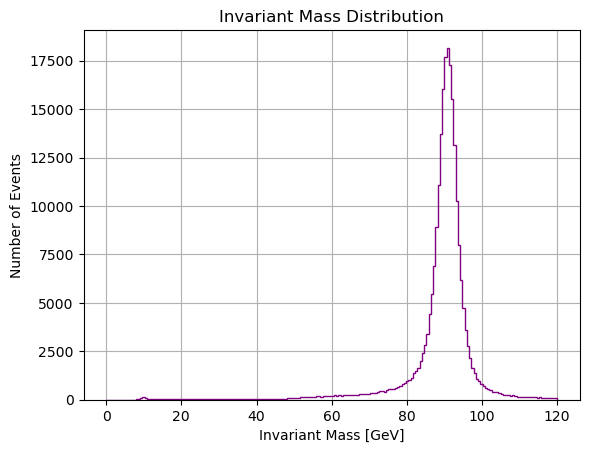

In [3]:
lep_pt_cut  = tree["lep_pt"].array()[combined_mask]
lep_phi_cut = tree["lep_phi"].array()[combined_mask]
lep_eta_cut = tree["lep_eta"].array()[combined_mask]
lep_E_cut   = tree["lep_E"].array()[combined_mask]

# Calculate momentums
lep_px = lep_pt_cut * np.cos(lep_phi_cut)
lep_py = lep_pt_cut * np.sin(lep_phi_cut)
lep_pz = lep_pt_cut * np.sinh(lep_eta_cut)

# 2 Lepton
exactly_two_mask = ak.num(lep_E_cut) == 2

lep_E_cut = lep_E_cut[exactly_two_mask]
lep_px = lep_px[exactly_two_mask]
lep_py = lep_py[exactly_two_mask]
lep_pz = lep_pz[exactly_two_mask]

# Mass Function

def mass(E1, E2, px1, px2, py1, py2, pz1, pz2):
    M2 = (E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2
    return np.sqrt(M2) / 1000  # Convert to GeV

E1 = lep_E_cut[:, 0]
E2 = lep_E_cut[:, 1]
px1 = lep_px[:, 0]
px2 = lep_px[:, 1]
py1 = lep_py[:, 0]
py2 = lep_py[:, 1]
pz1 = lep_pz[:, 0]
pz2 = lep_pz[:, 1]

mass_values = mass(E1, E2, px1, px2, py1, py2, pz1, pz2)

plt.hist(mass_values, bins=200, range=(0, 120), histtype='step', color='purple')
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Number of Events")
plt.title("Invariant Mass Distribution")
plt.grid(True)
plt.savefig("histogram3.png")
plt.show()



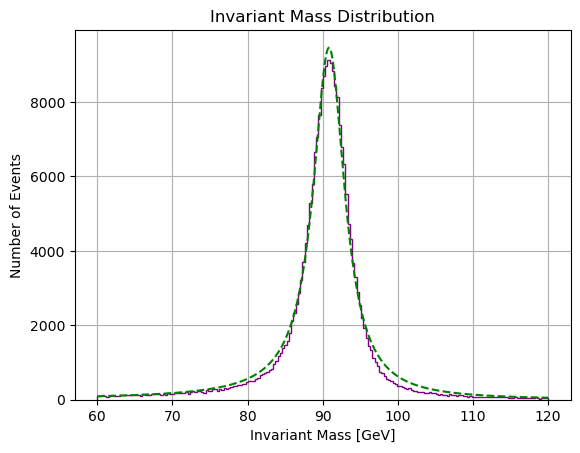

In [4]:
# Breit-Wigner 
def breit_wigner(mass, A, M0, Gamma):
    return A * Gamma**2 / ((mass**2 - M0**2)**2 + M0**2 * Gamma**2)

counts, bin_edges = np.histogram(mass_values, bins=200, range=(60, 120))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]

bin_centers = np.asarray(bin_centers)
counts = np.asarray(counts)

guess_A = max(counts)
guess_M0 = 91.2
guess_Gamma = 2.5
initial_guess = [guess_A, guess_M0, guess_Gamma]

# curve_fit 
from scipy.optimize import curve_fit
params, _ = curve_fit(breit_wigner, bin_centers, counts, p0=initial_guess)

A_fit, M0_fit, Gamma_fit = params

x_fit = np.linspace(60, 120, 500)
y_fit_bw = breit_wigner(x_fit, A_fit, M0_fit, Gamma_fit)

plt.hist(mass_values, bins=200, range=(60, 120), histtype='step', color='purple', label='Data')
plt.plot(x_fit, y_fit_bw, 'g--')
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Number of Events")
plt.title("Invariant Mass Distribution")
plt.grid(True)
plt.savefig("histogram4.png")
plt.show()

In [5]:
signal_region = (mass_values > 86) & (mass_values < 96)
background_region = ((mass_values > 60) & (mass_values < 80)) | ((mass_values > 100) & (mass_values < 120))

print(f"Signal events: {np.sum(signal_region)}")
print(f"Background events: {np.sum(background_region)}")


Signal events: 179655
Background events: 21048


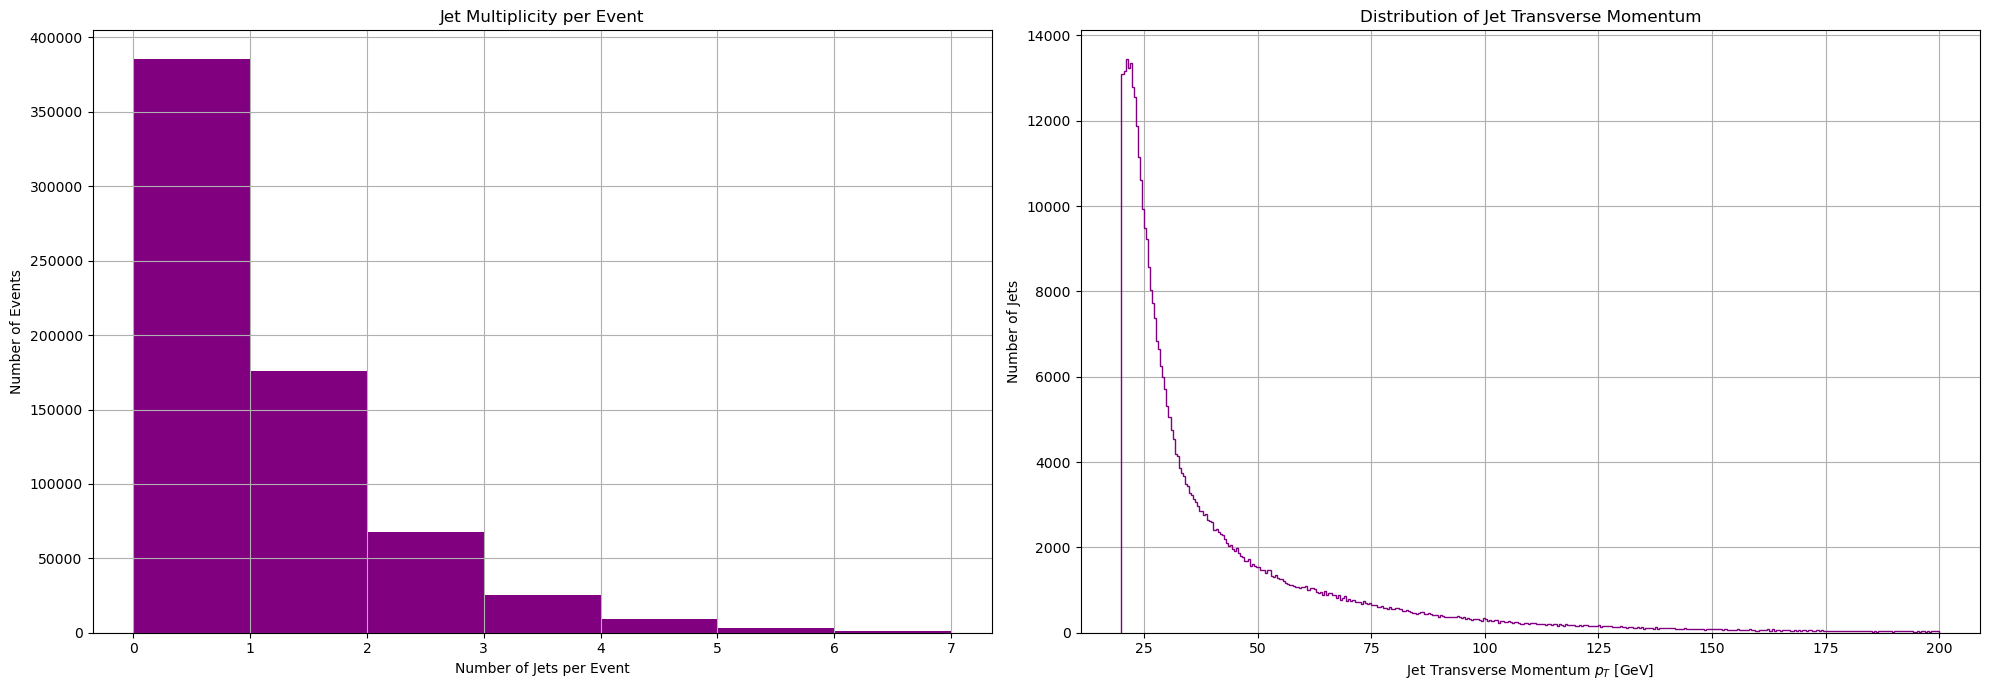

In [8]:
jet_n = tree["jet_n"].array()

jet_pt = tree["jet_pt"].array()
jet_pt_flat = ak.flatten(jet_pt)

jet_pt_new = jet_pt_flat / 1000

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Jet multiplicity (event başına jet sayısı)
ax[0].hist(jet_n, bins=7, range=(0, 7), color='purple')
ax[0].set_xlabel("Number of Jets per Event")  
ax[0].set_ylabel("Number of Events")
ax[0].set_title("Jet Multiplicity per Event") 
ax[0].grid(True)

# Jet transverse momentum
ax[1].hist(jet_pt_new, bins=400, range=(20, 200), histtype='step', color='purple')
ax[1].set_xlabel("Jet Transverse Momentum $p_T$ [GeV]")
ax[1].set_ylabel("Number of Jets")
ax[1].set_title("Distribution of Jet Transverse Momentum")
ax[1].grid(True)

plt.tight_layout()
fig.savefig("subplots.png")  
plt.show()
plt.show()


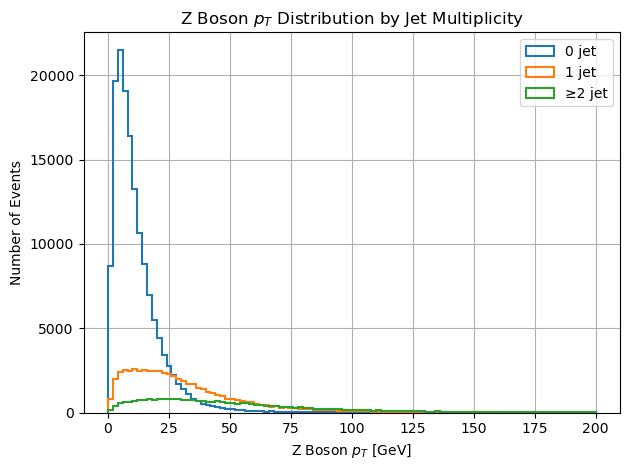

In [12]:
jet_n = tree["jet_n"].array()[combined_mask]

jet0 = jet_n == 0
jet1 = jet_n == 1
jet2more = jet_n >= 2

lep_pt = tree["lep_pt"].array()[combined_mask]
lep_phi = tree["lep_phi"].array()[combined_mask]

lep_px = lep_pt * np.cos(lep_phi)
lep_py = lep_pt * np.sin(lep_phi)

z_px = ak.sum(lep_px, axis=1)
z_py = ak.sum(lep_py, axis=1)

z_pt = np.sqrt(z_px**2 + z_py**2)

zpt_0jet = z_pt[jet0]
zpt_1jet = z_pt[jet1]
zpt_2more = z_pt[jet2more]

zpt_0jet = zpt_0jet / 1000
zpt_1jet = zpt_1jet / 1000
zpt_2more = zpt_2more / 1000

plt.hist(zpt_0jet, bins=100, range=(0, 200), histtype='step', label="0 jet", linewidth=1.5)
plt.hist(zpt_1jet, bins=100, range=(0, 200), histtype='step', label="1 jet", linewidth=1.5)
plt.hist(zpt_2more, bins=100, range=(0, 200), histtype='step', label="≥2 jet", linewidth=1.5)

plt.xlabel("Z Boson $p_T$ [GeV]")
plt.ylabel("Number of Events")
plt.title("Z Boson $p_T$ Distribution by Jet Multiplicity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("histogram6.png")
plt.show()

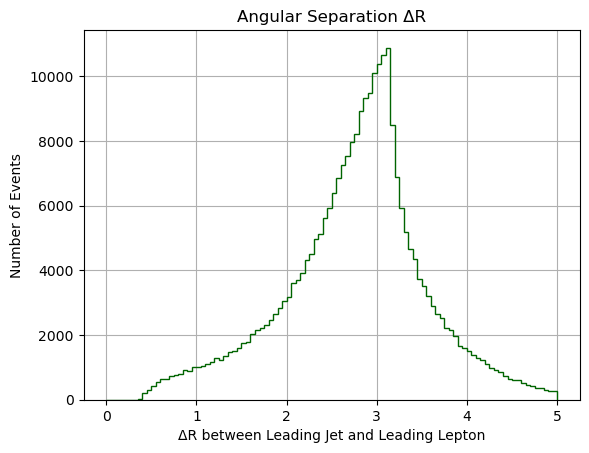

Isolated events: 282616
Isolated events: 10
Isolated data rate: (99.99646%)


In [13]:
jet_pt   = tree["jet_pt"].array()
jet_eta  = tree["jet_eta"].array()
jet_phi  = tree["jet_phi"].array()
jet_E    = tree["jet_E"].array()

lep_pt  = tree["lep_pt"].array()
lep_eta = tree["lep_eta"].array()
lep_phi = tree["lep_phi"].array()
lep_E   = tree["lep_E"].array()

jet_zip = ak.zip({
    "pt": jet_pt,
    "eta": jet_eta,
    "phi": jet_phi,
    "E": jet_E
})

jets = vector.Array(jet_zip) 

lep_zip = ak.zip({
    "pt": lep_pt,
    "eta": lep_eta,
    "phi": lep_phi,
    "E": lep_E
})

leptons = vector.Array(lep_zip)

mask = (ak.num(jets) > 0) & (ak.num(leptons) > 0)

jets_masked = jets[mask]
leptons_masked = leptons[mask]

deltaRs = jets_masked[:, 0].deltaR(leptons_masked[:, 0])

plt.hist(deltaRs, bins=100, range=(0, 5), histtype='step', color='darkgreen')
plt.xlabel("ΔR between Leading Jet and Leading Lepton")
plt.ylabel("Number of Events")
plt.title("Angular Separation ΔR")
plt.grid(True)
plt.savefig("histogram7.png")
plt.show()

n_isolated = ak.sum(deltaRs > 0.4)
n_total = len(deltaRs)
a = n_total - n_isolated
print(f"Isolated events: {n_isolated}")
print(f"Isolated events: {a}")
print(f"Isolated data rate: ({n_isolated/n_total*100:.5f}%)")

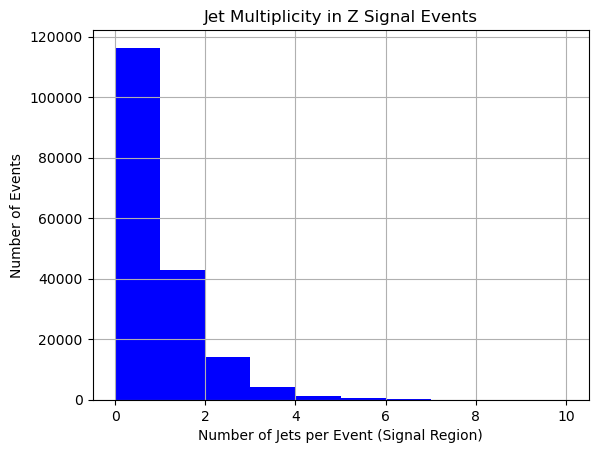

64.76246138431995
23.955358882302193
7.787704210848571
2.4185243939773455
0.7564498622359522
0.2309983023016337


In [14]:
signal_mask = (mass_values > 86) & (mass_values < 96)
jet_n_signal = jet_n[signal_mask]
plt.hist(jet_n_signal, bins=10, range=(0, 10), color='blue')
plt.xlabel("Number of Jets per Event (Signal Region)")
plt.ylabel("Number of Events")
plt.title("Jet Multiplicity in Z Signal Events")
plt.grid(True)
plt.savefig("histogram8.png")
plt.show()

print(np.sum(jet_n_signal == 0) / len(jet_n_signal)*100)
print(np.sum(jet_n_signal == 1) / len(jet_n_signal)*100)
print(np.sum(jet_n_signal == 2) / len(jet_n_signal)*100)
print(np.sum(jet_n_signal == 3) / len(jet_n_signal)*100)
print(np.sum(jet_n_signal == 4) / len(jet_n_signal)*100)
print(np.sum(jet_n_signal == 5) / len(jet_n_signal)*100)

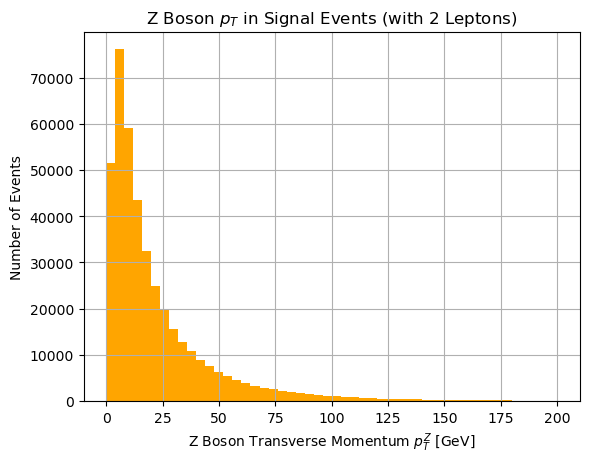

In [16]:
leptons = vector.Array(
    ak.zip({
        "pt": lep_pt,
        "eta": lep_eta,
        "phi": lep_phi,
        "E": lep_E
    })
)

mask_2lep = ak.num(leptons) == 2
leptons_2lep = leptons[mask_2lep]
lep0 = leptons_2lep[:, 0]
lep1 = leptons_2lep[:, 1]

mass_values_2lep = np.sqrt((lep0.E + lep1.E)**2 
                           - (lep0.px + lep1.px)**2 
                           - (lep0.py + lep1.py)**2 
                           - (lep0.pz + lep1.pz)**2)

mass_values_2lep = mass_values_2lep / 1000  # MeV → GeV

Z = lep0 + lep1
Z_pt = Z.pt / 1000  #  GeV

signal_mask = (mass_values_2lep > 86) & (mass_values_2lep < 96)
Z_pt_signal = Z_pt[signal_mask]

plt.hist(ak.to_numpy(Z_pt_signal), bins=50, range=(0, 200), color='orange')
plt.xlabel("Z Boson Transverse Momentum $p_T^Z$ [GeV]")
plt.ylabel("Number of Events")
plt.title("Z Boson $p_T$ in Signal Events (with 2 Leptons)")
plt.grid(True)
plt.savefig("histogram9.png")
plt.show()